In [1]:
%load_ext autoreload
%autoreload 2

# Classification

In [2]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"

from typing import Any, Callable, Sequence, Union
import numpy as np

import tensorflow as tf
tf.config.set_visible_devices([], device_type='GPU')

import jax
from jax import lax, random, numpy as jnp
from flax.core import freeze, unfreeze, FrozenDict
from flax import linen as nn
from flax import struct
from flax.training import train_state
from flax.training import orbax_utils

import optax
import orbax.checkpoint

from clu import metrics
from ml_collections import ConfigDict

from einops import reduce, rearrange
import wandb
from fxlayers.layers import *
from fxlayers.layers import GaussianLayerGamma, GaborLayerLogSigma_, GaborLayerLogSigmaCoupled_
from fxlayers.initializers import *
from JaxPlayground.utils.constraints import *
from JaxPlayground.utils.wandb import *

In [3]:
# jax.config.update("jax_debug_nans", False)

## Load the data

In [4]:
config = {
    "BATCH_SIZE": 64,
    "EPOCHS": 500,
    "LEARNING_RATE": 3e-3,
    "SEED": 42,
    'dataset': 'cifar10', # imagenet / imagenette / cifar10 / cifar100,
    'validation_split': 0.2,
    "GAP": True,
    "dropout_rate": 0.0,
    "GDN_CLIPPING": True,
    "NORMALIZE_PROB": False,
    "NORMALIZE_ENERGY": True,
    "ZERO_MEAN": True,
    "USE_BIAS": False,
    "N_SCALES": 4,
    "N_ORIENTATIONS": 8,
}
config = ConfigDict(config)
config

BATCH_SIZE: 64
EPOCHS: 500
GAP: true
GDN_CLIPPING: true
LEARNING_RATE: 0.003
NORMALIZE_ENERGY: true
NORMALIZE_PROB: false
N_ORIENTATIONS: 8
N_SCALES: 4
SEED: 42
USE_BIAS: false
ZERO_MEAN: true
dataset: cifar10
dropout_rate: 0.0
validation_split: 0.2

In [5]:
wandb.init(project='PerceptNetV2_Classification',
           name="V2",
           notes="",
           tags=[],
           config=config,
           job_type="training",
           mode="online",
            )
# config = wandb.config

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


In [6]:
def load_imagenet():
    path_data = Path("/lustre/ific.uv.es/ml/uv075/Databases/imagenet_images/")
    dst_train = tf.keras.utils.image_dataset_from_directory(
                path_data,
                validation_split=config.validation_split,
                subset="training",
                seed=config.SEED,
                shuffle=True,
                # image_size=(img_height, img_width),
                batch_size=config.BATCH_SIZE)
    dst_val = tf.keras.utils.image_dataset_from_directory(
                path_data,
                validation_split=config.validation_split,
                subset="validation",
                seed=config.SEED,
                shuffle=False,
                # image_size=(img_height, img_width),
                batch_size=config.BATCH_SIZE)
    return dst_train, dst_val

In [7]:
def load_imagenette():
    import tensorflow_datasets as tfds

    dst_train, info = tfds.load("imagenette/320px-v2", split=f"train[:{(1-config.validation_split)*100:.0f}%]", with_info=True, shuffle_files=True)
    dst_val = tfds.load("imagenette/320px-v2", split=f"train[{(1-config.validation_split)*100:.0f}%:]", with_info=False, shuffle_files=False)
    def prepare_tfds(item):
        x, y = item["image"], item["label"]
        x = tf.image.resize_with_crop_or_pad(x, 256, 256)
        return x, y
    dst_train = dst_train.map(prepare_tfds)
    dst_val = dst_val.map(prepare_tfds)

    return dst_train.batch(config.BATCH_SIZE), dst_val.batch(config.BATCH_SIZE), info.features["label"].num_classes

In [8]:
def load_cifar10():
    from tensorflow.keras.datasets import cifar10
    from sklearn.model_selection import train_test_split

    (X_train, Y_train), (X_test, Y_test) = cifar10.load_data()
    X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=config.validation_split, random_state=config.SEED)
    dst_train = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
    dst_val = tf.data.Dataset.from_tensor_slices((X_val, Y_val))

    return dst_train.batch(config.BATCH_SIZE), dst_val.batch(config.BATCH_SIZE)

In [9]:
def load_cifar100():
    from tensorflow.keras.datasets import cifar100
    from sklearn.model_selection import train_test_split

    (X_train, Y_train), (X_test, Y_test) = cifar100.load_data()
    X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=config.validation_split, random_state=config.SEED)
    dst_train = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
    dst_val = tf.data.Dataset.from_tensor_slices((X_val, Y_val))

    return dst_train.batch(config.BATCH_SIZE), dst_val.batch(config.BATCH_SIZE)

In [10]:
if config.dataset == "imagenet":
    dst_train, dst_val = load_imagenet()
    N_CLASSES = len(dst_train.class_names)
elif config.dataset == "cifar10":
    dst_train, dst_val = load_cifar10()
    N_CLASSES = 10
elif config.dataset == "cifar100":
    dst_train, dst_val = load_cifar100()
    N_CLASSES = 100
elif config.dataset == "imagenette":
    dst_train, dst_val, N_CLASSES = load_imagenette()
else:
    raise ValueError("Dataset parameter not allowed.")
print(f"Training on {config.dataset} with {N_CLASSES} classes.")

Training on cifar10 with 10 classes.


In [11]:
x, y = next(iter(dst_train))
input_shape = x[0].shape
input_shape, y.shape

(TensorShape([32, 32, 3]), TensorShape([64, 1]))

### Normalize the data

In [12]:
if len(y.shape) != 1:
    dst_train = dst_train.map(lambda x,y: (tf.cast(x, tf.float32)/255.0, y[:,0]))
    dst_val = dst_val.map(lambda x,y: (tf.cast(x, tf.float32)/255.0, y[:,0]))

### Performance

In [13]:
AUTOTUNE = tf.data.AUTOTUNE

dst_train_rdy = dst_train.cache().prefetch(buffer_size=1)
dst_val_rdy = dst_val.cache().prefetch(buffer_size=1)

In [14]:
wandb.run.summary["N_CLASSES"] = N_CLASSES
wandb.run.summary["Input_Shape"] = tuple(input_shape)

## Define the model we're going to use

> It's going to be a very simple model just for demonstration purposes.

In [15]:
#| export
class GDNGaussianStarRunning(nn.Module):
    """GDN variation where x^* is obtained as a running mean of the previously obtained values."""

    kernel_size: int
    inputs_star: float = 1.
    outputs_star: Union[None, float] = None
    fs: int = 1
    apply_independently: bool = False
    alpha: float = 2.
    epsilon: float = 1/2
    bias_init: Callable = nn.initializers.ones_init()

    @nn.compact
    def __call__(self,
                 inputs,
                 train=False,
                 **kwargs,
                 ):
        # inputs_sign = jnp.sign(inputs)
        # inputs = jnp.abs(inputs)
        is_initialized = self.has_variable("batch_stats", "inputs_star")
        # inputs_star = self.variable("batch_stats", "inputs_star", lambda x: x, jnp.quantile(inputs, q=0.95))
        inputs_star = self.variable("batch_stats", "inputs_star", lambda x: jnp.ones(x)*self.inputs_star, (1,))
        if is_initialized and train:
            inputs_star.value = (inputs_star.value + jnp.quantile(jnp.abs(inputs), q=0.95))/2
        H = GaussianLayerGamma(features=inputs.shape[-1], kernel_size=self.kernel_size, use_bias=True, fs=self.fs, xmean=self.kernel_size/self.fs/2, ymean=self.kernel_size/self.fs/2, bias_init=self.bias_init, normalize_prob=config.NORMALIZE_PROB, normalize_energy=config.NORMALIZE_ENERGY)
        inputs_star_ = jnp.ones_like(inputs)*inputs_star.value
        denom = jnp.clip(H(inputs**self.alpha, train=train), a_min=1e-5)**self.epsilon
        coef = (jnp.clip(H(inputs_star_**self.alpha, train=train), a_min=1e-5)**self.epsilon)#/inputs_star_
        if self.outputs_star is not None: coef = coef/inputs_star.value*self.outputs_star
        
        return coef*inputs/denom

In [16]:
class GDNSpatioFreqOrient(nn.Module):
    """Generalized Divisive Normalization."""
    kernel_size: Union[int, Sequence[int]]
    strides: int = 1
    padding: str = "SAME"
    inputs_star: float = 1.
    outputs_star: Union[None, float] = None
    fs: int = 1
    apply_independently: bool = False
    bias_init: Callable = nn.initializers.ones_init()
    alpha: float = 2.
    epsilon: float = 1/2 # Exponential of the denominator
    eps: float = 1e-6 # Numerical stability in the denominator

    @nn.compact
    def __call__(self,
                 inputs,
                 fmean,
                 theta_mean,
                 train=False,
                 ):
        b, h, w, c = inputs.shape
        bias = self.param("bias",
                          #equal_to(inputs_star/10),
                          self.bias_init,
                          (c,))
        is_initialized = self.has_variable("batch_stats", "inputs_star")
        inputs_star = self.variable("batch_stats", "inputs_star", lambda x: jnp.ones(x)*self.inputs_star, (len(self.inputs_star),))
        inputs_star_ = jnp.ones_like(inputs)*inputs_star.value
        GL = GaussianLayerGamma(features=c, kernel_size=self.kernel_size, strides=self.strides, padding=self.padding, fs=self.fs, xmean=self.kernel_size/self.fs/2, ymean=self.kernel_size/self.fs/2, normalize_prob=config.NORMALIZE_PROB, normalize_energy=config.NORMALIZE_ENERGY, use_bias=False, feature_group_count=c)
        FG = FreqGaussian()
        OG = OrientGaussian()
        outputs = GL(inputs**self.alpha, train=train)#/(self.kernel_size**2)
        outputs = FG(outputs, fmean=fmean)
        ## Reshape so that the orientations are the innermost dimmension
        outputs = rearrange(outputs, "b h w (phase theta f) -> b h w (phase f theta)", b=b, h=h, w=w, phase=2, f=config.N_SCALES, theta=config.N_ORIENTATIONS)
        outputs = OG(outputs, theta_mean=theta_mean)
        ## Recover original disposition
        denom = rearrange(outputs, "b h w (phase f theta) -> b h w (phase theta f)", b=b, h=h, w=w, phase=2, f=config.N_SCALES, theta=config.N_ORIENTATIONS)

        ## Coef
        coef = GL(inputs_star_**self.alpha, train=train)#/(self.kernel_size**2)
        coef = FG(coef, fmean=fmean)
        coef = rearrange(coef, "b h w (phase theta f) -> b h w (phase f theta)", b=b, h=h, w=w, phase=2, f=config.N_SCALES, theta=config.N_ORIENTATIONS)
        coef = OG(coef, theta_mean=theta_mean) + bias
        coef = rearrange(coef, "b h w (phase f theta) -> b h w (phase theta f)", b=b, h=h, w=w, phase=2, f=config.N_SCALES, theta=config.N_ORIENTATIONS)
        coef = jnp.clip(coef+bias, a_min=1e-5)**self.epsilon
        # coef = inputs_star.value * coef
        if self.outputs_star is not None: coef = coef/inputs_star.value*self.outputs_star

        if is_initialized and train:
            inputs_star.value = (inputs_star.value + jnp.quantile(jnp.abs(inputs), q=0.95, axis=(0,1,2)))/2
        return coef * inputs / (jnp.clip(denom+bias, a_min=1e-5)**self.epsilon + self.eps)

In [17]:
from pickle import load
with open("gabor_x_star.pkl", "rb") as f:
    gabor_x_star = load(f)

In [18]:
class PerceptNet(nn.Module):
    """IQA model inspired by the visual system."""

    @nn.compact
    def __call__(self,
                 inputs, # Assuming fs = 128 (cpd)
                 **kwargs,
                 ):
        ## (Independent) Color equilibration (Gamma correction)
        ## bias = 0.1 / kernel = 0.5
        outputs = GDNStarSign(kernel_size=(1,1), apply_independently=True, inputs_star=1.)(inputs)
        
        ## ATD Transformation
        outputs = JamesonHurvich()(outputs)
        outputs = nn.max_pool(outputs, window_shape=(2,2), strides=(2,2))
        
        ## GDN Star A - T - D [Separated]
        ### A
        outputs0 = GDNStarSign(kernel_size=(1,1), apply_independently=True, inputs_star=170.)(outputs[:,:,:,0:1])
        ### T
        outputs1 = GDNStarDisplacement(kernel_size=(1,1), apply_independently=True, inputs_star=55.)(outputs[:,:,:,1:2])
        outputs1 = outputs1*(2*55/170)
        ### D
        outputs2 = GDNStarDisplacement(kernel_size=(1,1), apply_independently=True, inputs_star=55.)(outputs[:,:,:,2:3])
        outputs2 = outputs2*(2*55/170)
        ### Put them back together
        outputs = jnp.concatenate([outputs0, outputs1, outputs2], axis=-1)

        ## Apply CSF on Fourier
        outputs = CSFFourier(fs=64, norm_energy=True)(outputs)
        outputs = nn.max_pool(outputs, window_shape=(2,2), strides=(2,2))

        ## GDN per channel with mean substraction in T and D (Spatial Gaussian Kernel)
        ## TO-DO: - Spatial Gaussian Kernel (0.02 deg) -> fs = 64/2 & 0.02*64/2 = sigma (px) = 0.69
        ### A
        ### (384/4, 512/4, 1)
        ### fs = 32 / kernel_size = (11,11) -> 0.32 > 0.02 --> OK!
        outputs0 = GDNGaussianStarRunning(kernel_size=11, apply_independently=True, bias_init=equal_to([0.1]), inputs_star=0.3, outputs_star=None, fs=32)(outputs[:,:,:,0:1], **kwargs)
        ### T
        outputs1 = GDNGaussianStarRunning(kernel_size=11, apply_independently=True, bias_init=equal_to([0.01**2]), inputs_star=0.06, outputs_star=None, fs=32)(outputs[:,:,:,1:2], **kwargs)
        ### D
        outputs2 = GDNGaussianStarRunning(kernel_size=11, apply_independently=True, bias_init=equal_to([0.01**2]), inputs_star=0.08, outputs_star=None, fs=32)(outputs[:,:,:,2:3], **kwargs)
        ### Put them back together
        outputs = jnp.concatenate([outputs0, outputs1, outputs2], axis=-1)

        ## GaborLayer per channel with GDN mixing only same-origin-channel information
        ### A
        outputs0, fmean, theta_mean = GaborLayerLogSigmaCoupled_(n_scales=config.N_SCALES, n_orientations=config.N_ORIENTATIONS, kernel_size=32, fs=32, strides=1, padding="SAME", normalize_prob=config.NORMALIZE_PROB, normalize_energy=config.NORMALIZE_ENERGY, zero_mean=config.ZERO_MEAN, use_bias=config.USE_BIAS)(outputs[:,:,:,0:1], return_freq=True, return_theta=True, **kwargs)
        ### [Gaussian] sigma = 0.2 (deg) fs = 32 / kernel_size = (21,21) -> 21/32 = 0.66 --> OK!
        outputs0 = GDNSpatioFreqOrient(kernel_size=21, strides=1, padding="SAME", fs=32, apply_independently=False, inputs_star=gabor_x_star["A"])(outputs0, fmean=fmean, theta_mean=theta_mean, **kwargs)
        ### T
        outputs1, fmean, theta_mean = GaborLayerLogSigmaCoupled_(n_scales=config.N_SCALES, n_orientations=config.N_ORIENTATIONS, kernel_size=32, fs=32, strides=1, padding="SAME", normalize_prob=config.NORMALIZE_PROB, normalize_energy=config.NORMALIZE_ENERGY, zero_mean=config.ZERO_MEAN, use_bias=config.USE_BIAS)(outputs[:,:,:,1:2], return_freq=True, return_theta=True, **kwargs)
        ### [Gaussian] sigma = 0.2 (deg) fs = 32 / kernel_size = (21,21) -> 21/32 = 0.66 --> OK!
        outputs1 = GDNSpatioFreqOrient(kernel_size=21, strides=1, padding="SAME", fs=32, apply_independently=False, inputs_star=gabor_x_star["T"])(outputs1, fmean=fmean, theta_mean=theta_mean, **kwargs)
        ### D
        outputs2, fmean, theta_mean = GaborLayerLogSigmaCoupled_(n_scales=config.N_SCALES, n_orientations=config.N_ORIENTATIONS, kernel_size=32, fs=32, strides=1, padding="SAME", normalize_prob=config.NORMALIZE_PROB, normalize_energy=config.NORMALIZE_ENERGY, zero_mean=config.ZERO_MEAN, use_bias=config.USE_BIAS)(outputs[:,:,:,2:3], return_freq=True, return_theta=True, **kwargs)
        ### [Gaussian] sigma = 0.2 (deg) fs = 32 / kernel_size = (21,21) -> 21/32 = 0.66 --> OK!
        outputs2 = GDNSpatioFreqOrient(kernel_size=21, strides=1, padding="SAME", fs=32, apply_independently=False, inputs_star=gabor_x_star["D"])(outputs2, fmean=fmean, theta_mean=theta_mean, **kwargs)

        ## Put them back together
        outputs = jnp.concatenate([outputs0, outputs1, outputs2], axis=-1)
        
        return outputs

We now have to add the classifier at the end

In [19]:
class Classifier(nn.Module):
    N_CLASSES: int
    GAP: bool = False
    dropout_rate: float = 0.5

    @nn.compact
    def __call__(self,
                 inputs,
                 train=False,
                 ):
        outputs = reduce(inputs, "b h w c -> b c", reduction="mean") if self.GAP else rearrange(inputs, "b h w c -> b (h w c)")
        # outputs = nn.Dropout(rate=self.dropout_rate, deterministic=not train)(outputs) if self.dropout_rate > 0.0 else outputs
        outputs = nn.Dense(self.N_CLASSES)(outputs)
        return outputs

In [20]:
class PerceptNetClassifier(nn.Module):
    def setup(self):
        self.perceptnet = PerceptNet()
        self.cls = Classifier(N_CLASSES=N_CLASSES, GAP=config.GAP, dropout_rate=config.dropout_rate)
    
    def __call__(self,
                 inputs,
                 train=False,
                 ):
        outputs = self.perceptnet(inputs, train=train)
        outputs = self.cls(outputs, train=train)
        return outputs

## Define the metrics with `clu`

In [21]:
@struct.dataclass
class Metrics(metrics.Collection):
    """Collection of metrics to be tracked during training."""
    accuracy: metrics.Accuracy
    loss: metrics.Average.from_output("loss")

By default, `TrainState` doesn't include metrics, but it's very easy to subclass it so that it does:

In [22]:
class TrainState(train_state.TrainState):
    metrics: Metrics
    state: FrozenDict

We'll define a function that initializes the `TrainState` from a module, a rng key and some optimizer:

In [23]:
def create_train_state(module, key, tx, input_shape):
    """Creates the initial `TrainState`."""
    variables = module.init(key, jnp.ones(input_shape))
    state, params = variables.pop('params')
    return TrainState.create(
        apply_fn=module.apply,
        params=params,
        state=state,
        tx=tx,
        metrics=Metrics.empty()
    )

## Defining the training step

> We want to write a function that takes the `TrainState` and a batch of data can performs an optimization step.

In [24]:
@jax.jit
def train_step(state, batch):
    """Train for a single step."""
    img, label = batch
    def loss_fn(params):
        ## Forward pass through the model
        img_pred, updated_state = state.apply_fn({"params": params, **state.state}, img, mutable=list(state.state.keys()), train=True)

        ## Calculate crossentropy
        loss = optax.softmax_cross_entropy_with_integer_labels(img_pred, label).mean()

        return loss, (updated_state, img_pred)
    
    (loss, (updated_state, img_pred)), grads = jax.value_and_grad(loss_fn, has_aux=True)(state.params)
    state = state.apply_gradients(grads=grads)
    metrics_updates = state.metrics.single_from_model_output(loss=loss, logits=img_pred, labels=jnp.round(label).astype(int))
    metrics = state.metrics.merge(metrics_updates)
    state = state.replace(metrics=metrics)
    state = state.replace(state=updated_state)
    return state

In their example, they don't calculate the metrics at the same time. I think it is kind of a waste because it means having to perform a new forward pass, but we'll follow as of now. Let's define a function to perform metric calculation:

In [25]:
@jax.jit
def compute_metrics(*, state, batch):
    """Obtaining the metrics for a given batch."""
    img, label = batch
    def loss_fn(params):
        ## Forward pass through the model
        img_pred = state.apply_fn({"params": params, **state.state}, img, train=False)
        
        ## Calculate crossentropy
        loss = optax.softmax_cross_entropy_with_integer_labels(img_pred, label).mean()
        
        return loss, img_pred
    
    loss, img_pred = loss_fn(state.params)
    metrics_updates = state.metrics.single_from_model_output(loss=loss, logits=img_pred, labels=jnp.round(label).astype(int))
    metrics = state.metrics.merge(metrics_updates)
    state = state.replace(metrics=metrics)
    return state

## Train the model!

In [26]:
state = create_train_state(PerceptNetClassifier(), random.PRNGKey(config.SEED), optax.adam(config.LEARNING_RATE), input_shape=(1,*input_shape))
state = state.replace(params=clip_layer(state.params, "GDN", a_min=0))

In [27]:
import flax

In [28]:
def check_trainable(path):
    return ("A" in path) or ("alpha_chrom_rg" in path) or ("alpha_chrom_yb" in path)

In [29]:
trainable_tree = freeze(flax.traverse_util.path_aware_map(lambda path, v: "non_trainable" if check_trainable(path)  else "trainable", state.params))
trainable_tree

FrozenDict({
    perceptnet: {
        GDNStarSign_0: {
            Conv_0: {
                kernel: 'trainable',
                bias: 'trainable',
            },
        },
        GDNStarSign_1: {
            Conv_0: {
                kernel: 'trainable',
                bias: 'trainable',
            },
        },
        GDNStarDisplacement_0: {
            Conv_0: {
                kernel: 'trainable',
                bias: 'trainable',
            },
        },
        GDNStarDisplacement_1: {
            Conv_0: {
                kernel: 'trainable',
                bias: 'trainable',
            },
        },
        CSFFourier_0: {
            alpha_achrom: 'trainable',
            alpha_chrom_rg: 'non_trainable',
            alpha_chrom_yb: 'non_trainable',
            beta_achrom: 'trainable',
            beta_chrom: 'trainable',
            fm: 'trainable',
            s: 'trainable',
        },
        GDNGaussianStarRunning_0: {
            GaussianLayerGamma_0: {
     

In [30]:
optimizers = {
    "trainable": optax.adam(learning_rate=config.LEARNING_RATE),
    "non_trainable": optax.set_to_zero(),
}

In [31]:
tx = optax.multi_transform(optimizers, trainable_tree)

In [32]:
state = create_train_state(PerceptNetClassifier(), random.PRNGKey(config.SEED), tx, input_shape=(1,384,512,3))
state = state.replace(params=clip_layer(state.params, "GDN", a_min=0))
state = state.replace(params=clip_layer(state.params, "alpha_achrom", a_min=1))

In [33]:
param_count = sum(x.size for x in jax.tree_util.tree_leaves(state.params))
param_count

2618

In [34]:
wandb.run.summary["trainable_parameters"] = param_count

In [35]:
state = state.replace(params=unfreeze(state.params))

## DN 0
state.params["perceptnet"]["GDNStarSign_0"]["Conv_0"]["bias"] = jnp.ones_like(state.params["perceptnet"]["GDNStarSign_0"]["Conv_0"]["bias"])*0.1
state.params["perceptnet"]["GDNStarSign_0"]["Conv_0"]["kernel"] = jnp.ones_like(state.params["perceptnet"]["GDNStarSign_0"]["Conv_0"]["kernel"])*0.5

## DN J&H
state.params["perceptnet"]["GDNStarSign_1"]["Conv_0"]["bias"] = jnp.ones_like(state.params["perceptnet"]["GDNStarSign_1"]["Conv_0"]["bias"])*30.**2
state.params["perceptnet"]["GDNStarSign_1"]["Conv_0"]["kernel"] = jnp.ones_like(state.params["perceptnet"]["GDNStarSign_1"]["Conv_0"]["kernel"])*0.5

state.params["perceptnet"]["GDNStarDisplacement_0"]["Conv_0"]["bias"] = jnp.ones_like(state.params["perceptnet"]["GDNStarDisplacement_0"]["Conv_0"]["bias"])*10.**2
state.params["perceptnet"]["GDNStarDisplacement_0"]["Conv_0"]["kernel"] = jnp.ones_like(state.params["perceptnet"]["GDNStarDisplacement_0"]["Conv_0"]["kernel"])*0.5

state.params["perceptnet"]["GDNStarDisplacement_1"]["Conv_0"]["bias"] = jnp.ones_like(state.params["perceptnet"]["GDNStarDisplacement_1"]["Conv_0"]["bias"])*10.**2
state.params["perceptnet"]["GDNStarDisplacement_1"]["Conv_0"]["kernel"] = jnp.ones_like(state.params["perceptnet"]["GDNStarDisplacement_1"]["Conv_0"]["kernel"])*0.5

state.params["perceptnet"]["GDNGaussianStarRunning_0"]["GaussianLayerGamma_0"]["gamma"] = jnp.ones_like(state.params["perceptnet"]["GDNGaussianStarRunning_0"]["GaussianLayerGamma_0"]["gamma"])*(1./0.04)
state.params["perceptnet"]["GDNGaussianStarRunning_1"]["GaussianLayerGamma_0"]["gamma"] = jnp.ones_like(state.params["perceptnet"]["GDNGaussianStarRunning_1"]["GaussianLayerGamma_0"]["gamma"])*(1./0.04)
state.params["perceptnet"]["GDNGaussianStarRunning_2"]["GaussianLayerGamma_0"]["gamma"] = jnp.ones_like(state.params["perceptnet"]["GDNGaussianStarRunning_2"]["GaussianLayerGamma_0"]["gamma"])*(1./0.04)

state.params["perceptnet"]["GDNSpatioFreqOrient_1"]["GaussianLayerGamma_0"]["gamma"] = jnp.ones_like(state.params["perceptnet"]["GDNSpatioFreqOrient_1"]["GaussianLayerGamma_0"]["gamma"])*(1./0.1)
state.params["perceptnet"]["GDNSpatioFreqOrient_2"]["GaussianLayerGamma_0"]["gamma"] = jnp.ones_like(state.params["perceptnet"]["GDNSpatioFreqOrient_2"]["GaussianLayerGamma_0"]["gamma"])*(1./0.1)
state.params["perceptnet"]["GDNSpatioFreqOrient_0"]["GaussianLayerGamma_0"]["gamma"] = jnp.ones_like(state.params["perceptnet"]["GDNSpatioFreqOrient_0"]["GaussianLayerGamma_0"]["gamma"])*(1./0.1)

state.params["perceptnet"]["GDNSpatioFreqOrient_0"]["OrientGaussian_0"]["sigma"] = jnp.ones_like(state.params["perceptnet"]["GDNSpatioFreqOrient_0"]["OrientGaussian_0"]["sigma"])*20
state.params["perceptnet"]["GDNSpatioFreqOrient_1"]["OrientGaussian_0"]["sigma"] = jnp.ones_like(state.params["perceptnet"]["GDNSpatioFreqOrient_1"]["OrientGaussian_0"]["sigma"])*20
state.params["perceptnet"]["GDNSpatioFreqOrient_2"]["OrientGaussian_0"]["sigma"] = jnp.ones_like(state.params["perceptnet"]["GDNSpatioFreqOrient_2"]["OrientGaussian_0"]["sigma"])*20

state.params["perceptnet"]["GDNSpatioFreqOrient_0"]["bias"] = jnp.tile(jnp.array([0.001, 0.002, 0.0035, 0.01])/100, reps=config.N_ORIENTATIONS*2)
state.params["perceptnet"]["GDNSpatioFreqOrient_1"]["bias"] = jnp.tile(jnp.array([0.001, 0.002, 0.0035, 0.01])/100, reps=config.N_ORIENTATIONS*2)
state.params["perceptnet"]["GDNSpatioFreqOrient_2"]["bias"] = jnp.tile(jnp.array([0.001, 0.002, 0.0035, 0.01])/100, reps=config.N_ORIENTATIONS*2)


state = state.replace(params=freeze(state.params))

Before actually training the model we're going to set up the checkpointer to be able to save our trained models:

In [36]:
orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
save_args = orbax_utils.save_args_from_target(state)

In [37]:
metrics_history = {
    "train_loss": [],
    "train_accuracy": [],
    "val_loss": [],
    "val_accuracy": [],
}

In [38]:
batch = next(iter(dst_train_rdy.as_numpy_iterator()))
batch[0].shape, batch[1].shape

2023-11-06 12:42:26.103295: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


((64, 32, 32, 3), (64,))

In [39]:
from functools import partial

In [40]:
@jax.jit
def forward(state, inputs):
    return state.apply_fn({"params": state.params, **state.state}, inputs, train=False)

In [41]:
%%time
outputs = forward(state, batch[0])
outputs.shape

CPU times: user 2.39 s, sys: 60.5 ms, total: 2.45 s
Wall time: 1.44 s


(64, 10)

In [42]:
%%time
s1 = train_step(state, batch)

CPU times: user 15.2 s, sys: 308 ms, total: 15.5 s
Wall time: 11.9 s


In [38]:
# jax.config.update("jax_debug_nans", True)

In [ ]:
%%time
for epoch in range(config.EPOCHS):
    ## Training
    for batch in dst_train_rdy.as_numpy_iterator():
        state = train_step(state, batch)
        state = state.replace(params=clip_layer(state.params, "GDN", a_min=0))
        state = state.replace(params=clip_layer(state.params, "alpha_achrom", a_min=1))
        # state = compute_metrics(state=state, batch=batch)
        # break

    ## Log the metrics
    for name, value in state.metrics.compute().items():
        metrics_history[f"train_{name}"].append(value)
    
    ## Empty the metrics
    state = state.replace(metrics=state.metrics.empty())

    ## Evaluation
    for batch in dst_val_rdy.as_numpy_iterator():
        state = compute_metrics(state=state, batch=batch)
        # break
    for name, value in state.metrics.compute().items():
        metrics_history[f"val_{name}"].append(value)
    state = state.replace(metrics=state.metrics.empty())
    
    ## Checkpointing
    if metrics_history["val_loss"][-1] <= min(metrics_history["val_loss"]):
        orbax_checkpointer.save(os.path.join(wandb.run.dir, "model-best"), state, save_args=save_args, force=True) # force=True means allow overwritting.

    wandb.log({f"{k}": wandb.Histogram(v) for k, v in flatten_params(state.params).items()}, commit=False)
    wandb.log({"epoch": epoch+1, **{name:values[-1] for name, values in metrics_history.items()}})
    print(f'Epoch {epoch} -> [Train] Loss: {metrics_history["train_loss"][-1]} [Val] Loss: {metrics_history["val_loss"][-1]}')
    # break

Save the final model as well in case we want to keep training from it or whatever:

In [ ]:
orbax_checkpointer.save(os.path.join(wandb.run.dir, "model-final"), state, save_args=save_args)

In [ ]:
wandb.finish()

epoch,452
train_loss,-0.89585
trainable_parameters,724
val_loss,-0.89161


In [80]:
import matplotlib.pyplot as plt

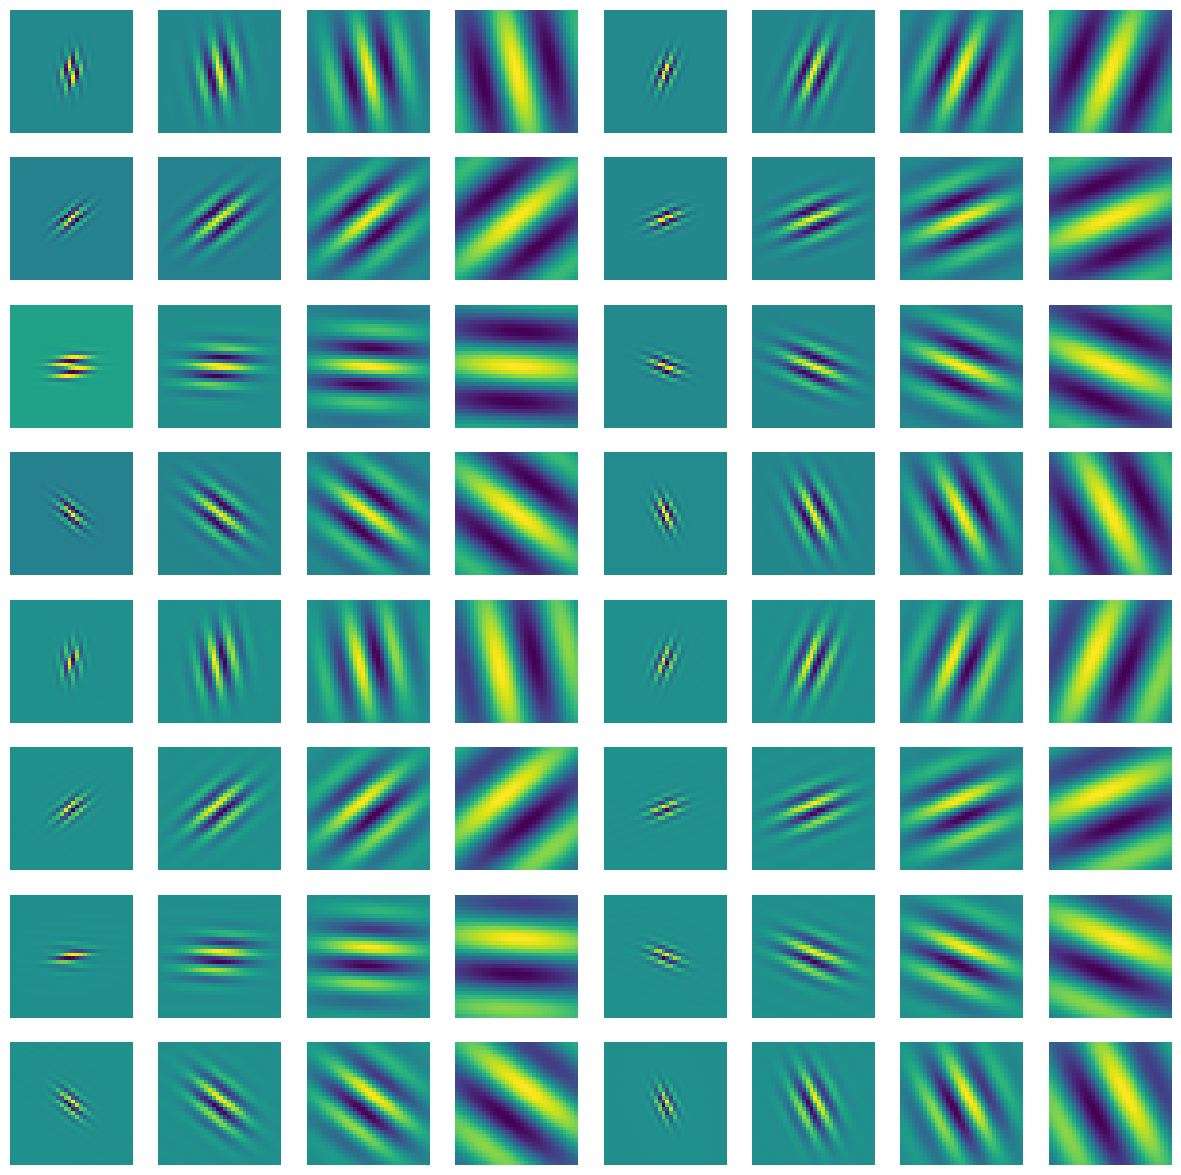

In [83]:
fig, axes = plt.subplots(8,8, figsize=(15,15))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(state.state["precalc_filter"]["perceptnet"]["GaborLayerLogSigma__0"]["kernel"][:,:,0,i])
    ax.axis("off")
plt.show()

In [165]:
kernel = state.state["precalc_filter"]["perceptnet"]["GaborLayerLogSigmaCoupled__2"]["kernel"]
kernel.shape

(32, 32, 1, 64)

In [166]:
kernel_f_fft = jnp.fft.fftn(kernel[:,:,0,:], axes=(0,1))
kernel_f_fft = jnp.fft.fftshift(kernel_f_fft)
kernel_f_fft_abs_sum = jnp.abs(kernel_f_fft).sum(axis=-1)
kernel_f_fft.shape, kernel_f_fft_abs_sum.shape

((32, 32, 64), (32, 32))

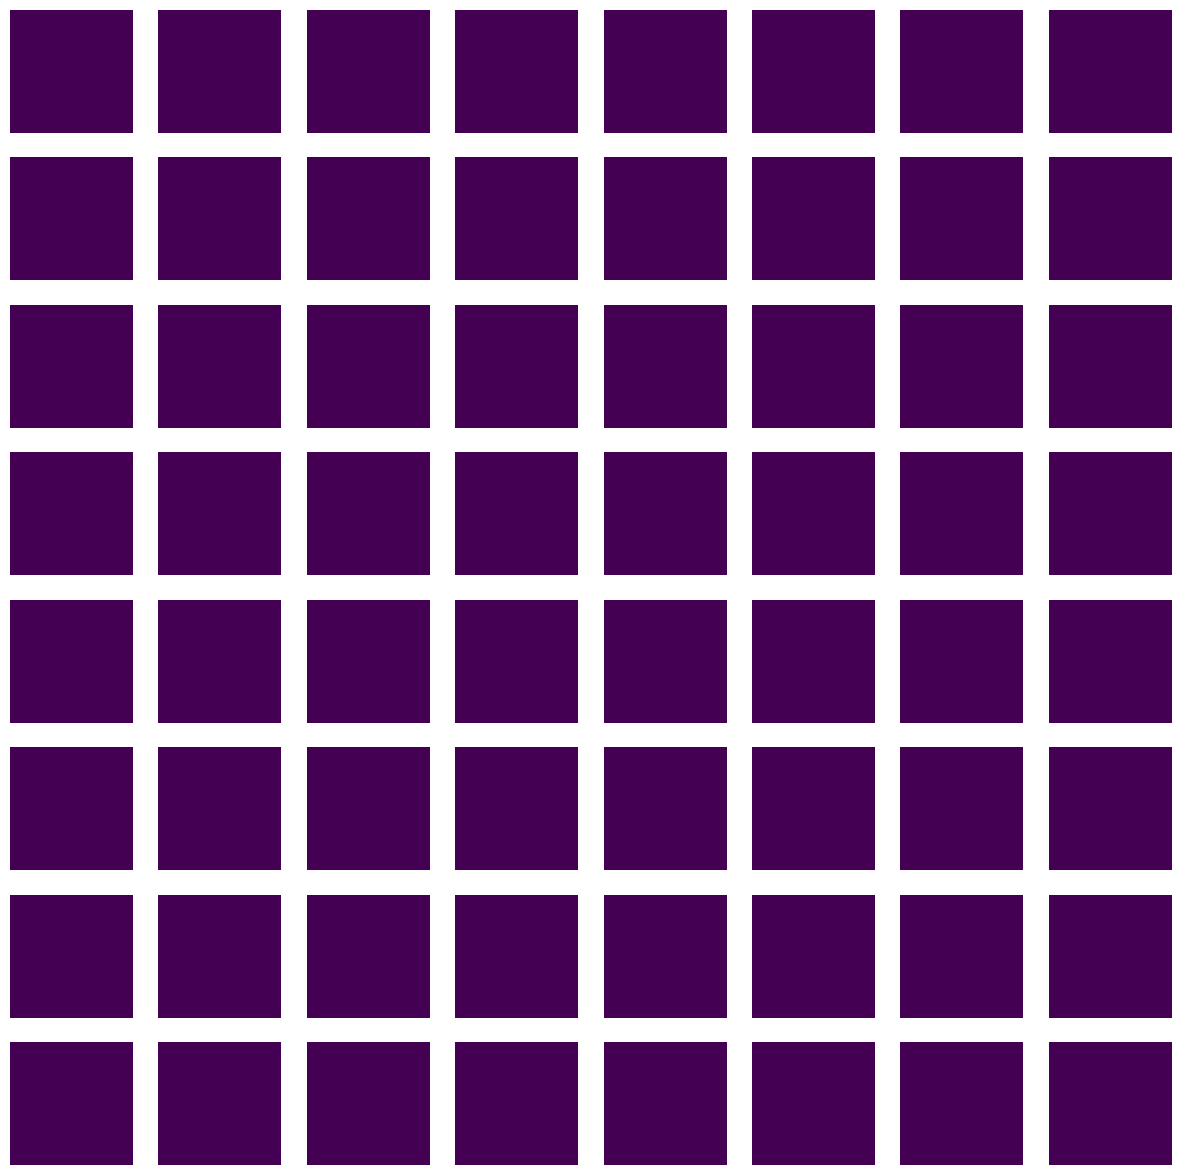

In [167]:
fig, axes = plt.subplots(8,8, figsize=(15,15))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(jnp.abs(kernel_f_fft[:,:,i]))
    ax.axis("off")
plt.show()

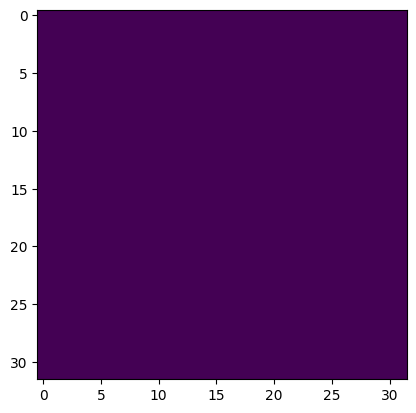

In [168]:
plt.imshow(kernel_f_fft_abs_sum)
plt.show()

In [ ]:
state.params["CSFFourier_0"]

FrozenDict({
    alpha_achrom: Array(1.0020298, dtype=float32),
    alpha_chrom_rg: Array(1., dtype=float32),
    alpha_chrom_yb: Array(1., dtype=float32),
    beta_achrom: Array(0.7361778, dtype=float32),
    beta_chrom: Array(0.09076351, dtype=float32),
    fm: Array(5.6491947, dtype=float32),
    s: Array(3.0281656, dtype=float32),
})

In [171]:
csf_sso, fx, fy = CSFFourier.csf_sso(fs=64, Nx=512//2, Ny=384//2, alpha=state.params["perceptnet"]["CSFFourier_0"]["alpha_achrom"],
                   beta=state.params["perceptnet"]["CSFFourier_0"]["beta_achrom"], g=330.74, fm=state.params["perceptnet"]["CSFFourier_0"]["fm"], 
                    l=0.837, s=state.params["perceptnet"]["CSFFourier_0"]["s"], w=1.0, os=6.664)

In [172]:
csf_chrom_rg, csf_chrom_yb, fx, fy = CSFFourier.csf_chrom(fs=64, Nx=512//2, Ny=384//2, alpha_rg=state.params["perceptnet"]["CSFFourier_0"]["alpha_chrom_rg"],
                   alpha_yb=state.params["perceptnet"]["CSFFourier_0"]["alpha_chrom_yb"],
                   beta=state.params["perceptnet"]["CSFFourier_0"]["beta_chrom"])

In [173]:
def scale_csf(csf_a, csf_rg, csf_yb):
    csfs = jnp.stack([csf_a, csf_rg, csf_yb], axis=-1)
    E1 = jnp.sum(jnp.ones_like(csfs)**2)#**(1/2)
    E_CSF = jnp.sum(csfs**2)#**(1/2)
    csfs = (csfs/E_CSF)*E1
    return csfs[:,:,0], csfs[:,:,1], csfs[:,:,2], csfs.min(), csfs.max()

In [174]:
csf_sso, csf_chrom_rg, csf_chrom_yb, m, M = scale_csf(csf_sso, csf_chrom_rg, csf_chrom_yb)
# csfs = scale_csf(csf_sso, csf_chrom_rg, csf_chrom_yb)

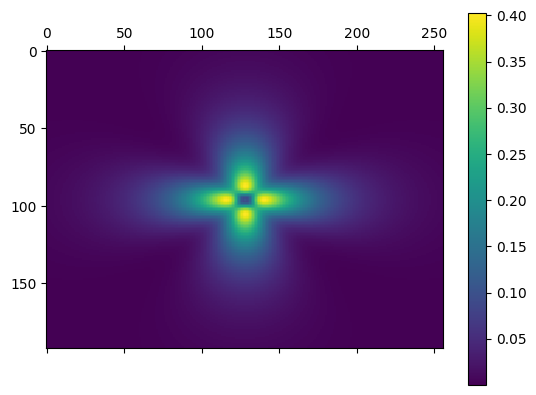

In [175]:
plt.matshow(csf_sso, vmin=m, vmax=M)
plt.colorbar()
plt.show()

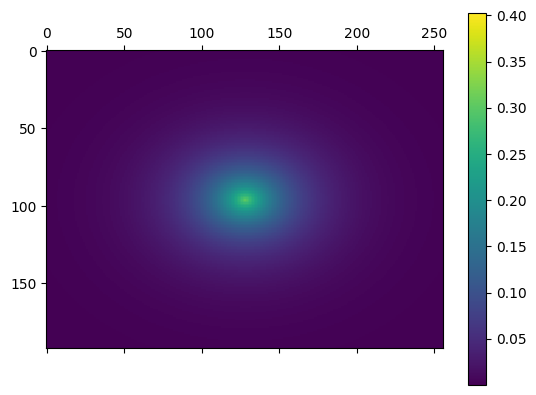

In [176]:
plt.matshow(csf_chrom_rg, vmin=m, vmax=M)
plt.colorbar()
plt.show()

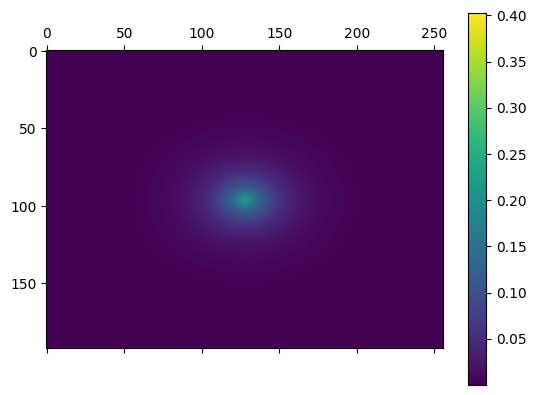

In [177]:
plt.matshow(csf_chrom_yb, vmin=m, vmax=M)
plt.colorbar()
plt.show()

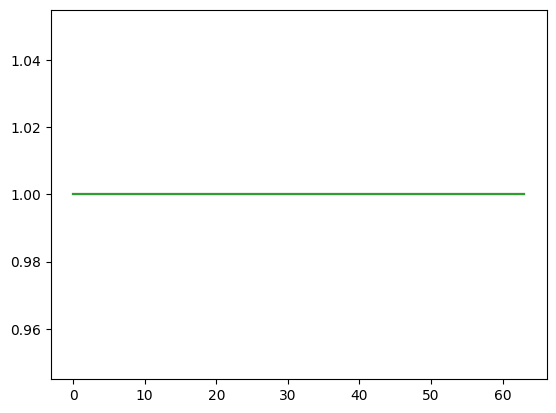

In [179]:
plt.plot(state.params["perceptnet"]["GDNSpatioFreqOrient_0"]["bias"])
plt.plot(state.params["perceptnet"]["GDNSpatioFreqOrient_1"]["bias"])
plt.plot(state.params["perceptnet"]["GDNSpatioFreqOrient_2"]["bias"])
plt.show()